# Molecular dynamics analysis

This Jupyter notebook presents a molecular dynamics analysis of the ADP-ribose binding site in ADRP domain from SARS-CoV-2 (PDB ID: 6W02). We simulated ADRP domain without its ligand, APR, for 600 ns. Then, a total of 600 frames were extracted at regular intervals of 1 ns from the molecular dynamics’ trajectory.

Here, we show cavity detection and characterization on ADRP domain from SARS-CoV-2 (PDB ID: 6W02), our reference. Further, we performed a occurence of cavity points, that were detected in at least two frames, and we plotted all properties (volume, area, depth and hydropathy) throughout the simulation.

# Requirements

In [1]:
# Import required modules
import os
import toml
import zipfile
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import pyKVFinder
import nglview

In [2]:
# Unzip required files
if not os.path.isdir('./data'):
    with zipfile.ZipFile('./data.zip', 'r') as zipped:
        zipped.extractall('./data')

In [3]:
# Get all frames of the molecular dynamics simulation
frames = [f for f in sorted(os.listdir('./data')) if f.endswith('.pdb')][:-2]
print(frames)

# Get ligand pdb
ligand = './data/APR.pdb'

# Get reference protein
reference = './data/reference.pdb'

['001.pdb', '002.pdb', '003.pdb', '004.pdb', '005.pdb', '006.pdb', '007.pdb', '008.pdb', '009.pdb', '010.pdb', '011.pdb', '012.pdb', '013.pdb', '014.pdb', '015.pdb', '016.pdb', '017.pdb', '018.pdb', '019.pdb', '020.pdb', '021.pdb', '022.pdb', '023.pdb', '024.pdb', '025.pdb', '026.pdb', '027.pdb', '028.pdb', '029.pdb', '030.pdb', '031.pdb', '032.pdb', '033.pdb', '034.pdb', '035.pdb', '036.pdb', '037.pdb', '038.pdb', '039.pdb', '040.pdb', '041.pdb', '042.pdb', '043.pdb', '044.pdb', '045.pdb', '046.pdb', '047.pdb', '048.pdb', '049.pdb', '050.pdb', '051.pdb', '052.pdb', '053.pdb', '054.pdb', '055.pdb', '056.pdb', '057.pdb', '058.pdb', '059.pdb', '060.pdb', '061.pdb', '062.pdb', '063.pdb', '064.pdb', '065.pdb', '066.pdb', '067.pdb', '068.pdb', '069.pdb', '070.pdb', '071.pdb', '072.pdb', '073.pdb', '074.pdb', '075.pdb', '076.pdb', '077.pdb', '078.pdb', '079.pdb', '080.pdb', '081.pdb', '082.pdb', '083.pdb', '084.pdb', '085.pdb', '086.pdb', '087.pdb', '088.pdb', '089.pdb', '090.pdb', '091.pdb'

In [4]:
# Define a common custom box using parKVFinder's PyMOL plugin
box = {
    'box':{
        'p1': [ 2.03, -3.97, 7.72,],
        'p2': [ 18.93, -3.97, 7.72,],
        'p3': [ 2.03, 16.23, 7.72,],
        'p4': [ 2.03, -3.97, 33.72,],
    }
}

# Write common custom box to file
with open('box.toml', 'w') as f:
    toml.dump(box, f)

# Cavity detection and characterization on reference

In [5]:
# Detect and characterize cavities on reference
results = pyKVFinder.pyKVFinder(reference, probe_out=12.0, volume_cutoff=100.0, box='./box.toml', include_depth=True, include_hydropathy=True, ignore_backbone=True)

# Export cavities and results
results.export_all(fn='./results/6W02/6W02.results.toml', output='./results/6W02/6W02.output.pdb', output_hydropathy='./results/6W02/6W02.EisenbergWeiss.pdb', include_frequencies_pdf=True, pdf='./results/6W02/6W02.histograms.pdf')

In [6]:
# Visualize depth of cavity points (rainbow scale)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Disply referece 6W02 as grey cartoon
pdb = view.add_component(reference)
pdb.clear()
pdb.add_cartoon(color='grey', opacity=0.5)

# Display ligand
lig = view.add_component(ligand)
lig.clear()
lig.add_licorice(color='red')

# Display cavities colored by depth
cavs = view.add_component('./results/6W02/6W02.output.pdb')
cavs.clear()
cavs.add_surface(colorScheme='bfactor', colorScale='rainbow', colorReverse=True, surfaceType='vws', probeRadius=0.3, opacity=0.8)

# Display on NGL viewer
view

NGLWidget()

In [7]:
# Visualize hydropathy of surface points (yellow-white-blue scale)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Disply referece 6W02 as grey cartoon
pdb = view.add_component(reference)
pdb.clear()
pdb.add_cartoon(color='grey', opacity=0.5)

# Display ligand
lig = view.add_component(ligand)
lig.clear()
lig.add_licorice(color='red')

# Display surface points colored by hydrophobicity
cavs = view.add_component('./results/6W02/6W02.EisenbergWeiss.pdb')
cavs.clear()
cavs.add_surface(colorScheme='bfactor', colorMode='rgb', colorScale=[0xFFFF00, 0xffffff, 0x0000FF], surfaceType='vws', probeRadius=0.3, opacity=0.8)

# Display on NGL viewer
view

NGLWidget()

# Occurrence analysis

In [8]:
# Read ligand coordinates
latomic = pyKVFinder.read_pdb(ligand)

# Create empty array
occurrence = None

for frame in frames:
    # Load atomic data
    atomic = pyKVFinder.read_pdb(os.path.join('./data', frame))
    
    # Get vertices from file
    vertices, atomic = pyKVFinder.get_vertices_from_file('./box.toml', atomic, probe_out=12.0)
    
    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(atomic, vertices, probe_out=12.0, box_adjustment=True, latomic=latomic)
    
    if occurrence is None:
        occurrence = (cavities > 1).astype(int)
    else:
        occurrence += (cavities > 1).astype(int)

# Get percentage of occurence
percentage = (occurrence/len(frames)) * 100

# Get cavity points
cavities = ((occurrence > 0).astype('int32'))
cavities += cavities

# Export cavities with percentage of occurrence in B-factor column
pyKVFinder.export('./results/md/occurrence.pdb', cavities, None, vertices, B=percentage) 

In [9]:
# Visualize the occurrence (%) of cavity points throughout the simulation

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Disply referece 6W02 as grey cartoon
pdb = view.add_component(reference)
pdb.clear()
pdb.add_cartoon(color='grey', opacity=0.5)

# Display ligand
lig = view.add_component(ligand)
lig.clear()
lig.add_licorice(color='red')

# Display surface points colored by hydrophobicity
cavs = view.add_component('./results/md/occurrence.pdb')
cavs.clear()
cavs.add_point(colorScheme='bfactor',colorScale='rainbow', colorReverse=True)

# Display on NGL viewer
view

NGLWidget()

# Properties throughout the simulation

In [10]:
# Calculating depth

# Read ligand coordinates
latomic = pyKVFinder.read_pdb(ligand)

# Depths
depth = numpy.zeros((2, len(frames)))

for frame in frames:
    # Get frame number
    num = (int(frame.replace('.pdb', '')))

    # Load atomic data
    atomic = pyKVFinder.read_pdb(os.path.join('./data', frame))

    # Get vertices from file
    vertices, atomic = pyKVFinder.get_vertices_from_file('./box.toml', atomic, probe_out=8.0)

    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(atomic, vertices, probe_out=12.0, box_adjustment=True, latomic=latomic)

    # Depth characterization
    depths, max_depth, avg_depth = pyKVFinder.depth(cavities)

    # Accumulate
    depth[0, num-1] = max(max_depth.values())
    depth[1, num-1] = max(avg_depth.values())

    # Export cavity
    pyKVFinder.export(f'./results/md/depth/{num}.pdb', cavities, None, vertices, B=depths, model=num)

## Depth

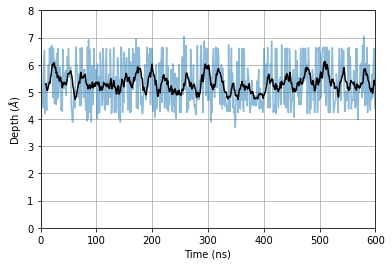

In [11]:
# Lineplot for depth characterization

# Prepare data
data = pd.DataFrame(depth, index=['Maximum', 'Average']).replace(0.0, numpy.nan).transpose()

# Plot data points
ax = data['Maximum'].plot.line(alpha=0.5)

# Plot moving average
data['moving_average'] = data.iloc[:, data.columns.get_loc('Maximum')].rolling(window=10).mean()
ax.plot('moving_average', data=data, color='black')

# Customize axis
ax.set_ylim(0, 8)
ax.set_xlim(0, 600)
ax.set_ylabel(r'Depth ($\AA$)')
ax.set_xlabel('Time (ns)')
ax.grid(True)

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/maximum_depth.png', dpi=300)

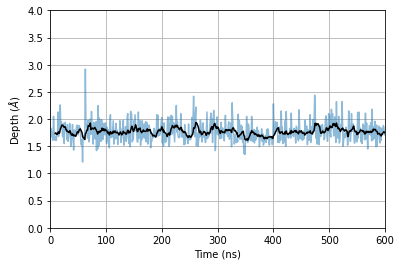

In [12]:
# Lineplot for depth characterization

# Prepare data
data = pd.DataFrame(depth, index=['Maximum', 'Average']).replace(0.0, numpy.nan).transpose()

# Plot data points
ax = data['Average'].plot.line(alpha=0.5)

# Plot moving average
data['moving_average'] = data.iloc[:, data.columns.get_loc('Average')].rolling(window=10).mean()
ax.plot('moving_average', data=data, color='black')

# Customize axis
ax.set_ylim(0, 4)
ax.set_xlim(0, 600)
ax.set_ylabel(r'Depth ($\AA$)')
ax.set_xlabel('Time (ns)')
ax.grid(True)

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/average_depth.png', dpi=300)

In [13]:
# Calculating volume, area and hydropathy

# Hydropathy
hydropathy = numpy.zeros((len(frames)))
volarea = numpy.zeros((2, len(frames)))

for frame in frames:
    # Get model number
    num = (int(frame.replace('.pdb', '')))

    # Load atomic data
    atomic = pyKVFinder.read_pdb(os.path.join('./data', frame))

    # Get vertices from file
    vertices, atomic = pyKVFinder.get_vertices_from_file('./box.toml', atomic, probe_out=12.0)

    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(atomic, vertices, probe_out=12.0, box_adjustment=True)

    # Spatial characterization
    surface, volume, area = pyKVFinder.spatial(cavities)

    # Accumulate volume and area
    volarea[0, num-1] = max(volume.values())
    volarea[1, num-1] = max(area.values())
    
    # Hydropathy characterization
    scales, avg_hydropathy = pyKVFinder.hydropathy(surface, atomic, vertices, ignore_backbone=True)

    # Get index of larger cavity
    index = list(volume.values()).index(max(volume.values()))
    
    # Accumulate hydropathy
    avg_hydropathy.popitem()
    hydropathy[num-1] = list(avg_hydropathy.values())[index]

    # Export cavity
    pyKVFinder.export(None, None, surface, vertices, output_hydropathy=f'./results/md/hydropathy/{num}.pdb', scales=scales, model=num)

## Volume

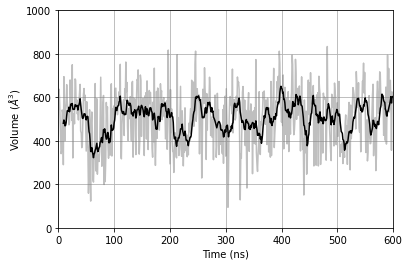

In [14]:
# Lineplot for volume characterization

# Prepare data
data = pd.DataFrame(volarea, index=['Volume', 'Area']).transpose().replace(0, numpy.nan)

# Plot data points
ax = data['Volume'].plot.line(color='gray', alpha=0.5)

# Plot moving average
data['moving_average'] = data.iloc[:, data.columns.get_loc('Volume')].rolling(window=10).mean()
ax.plot('moving_average', data=data, color='black')

# # Customize axis
ax.set_ylim(0, 1000)
ax.set_xlim(0, 600)
ax.set_ylabel('Volume ($\AA^3$)')
ax.set_xlabel('Time (ns)')
ax.grid(True)

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/volume.png', dpi=300)

## Area

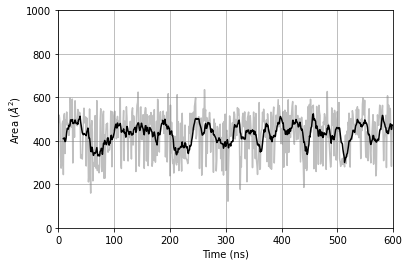

In [15]:
# Lineplot for volume characterization

# Prepare data
data = pd.DataFrame(volarea, index=['Volume', 'Area']).transpose().replace(0, numpy.nan)

# Plot data points
ax = data['Area'].plot.line(color='gray', alpha=0.5)

# Plot moving average
data['moving_average'] = data.iloc[:, data.columns.get_loc('Area')].rolling(window=10).mean()
ax.plot('moving_average', data=data, color='black')

# # Customize axis
ax.set_ylim(0, 1000)
ax.set_xlim(0, 600)
ax.set_ylabel(r'Area ($\AA^2$)')
ax.set_xlabel('Time (ns)')
ax.grid(True)

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/volume.png', dpi=300)

## Hydropathy

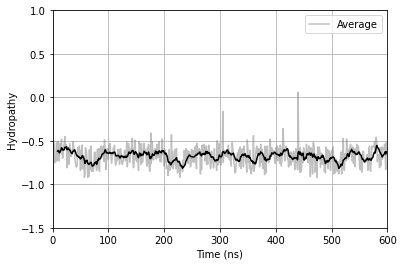

In [16]:
# Lineplot for hydropathy characterization

# Prepare data
data = pd.DataFrame(hydropathy, columns=['Average']).replace(0.0, numpy.nan)

# Plot data points
ax = data.plot.line(color='gray', alpha=0.5)

# Plot moving average
data['moving_average'] = data.iloc[:, data.columns.get_loc('Average')].rolling(window=10).mean()
ax.plot('moving_average', data=data, color='black')

# Customize axis
ax.set_ylim(-1.5, 1.0)
ax.set_xlim(0, 600)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Hydropathy')
ax.grid(True)

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/hydropathy.png', dpi=300)